In [11]:
!pip install lightning-bolts

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.0/330.0 kB 13.8 MB/s eta 0:00:00
  Using cached lightning_utilities-0.8.0-py3-none-any.whl (20 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 39.1 MB/s eta 0:00:00


In [12]:
from model import CropAndWeedDataModule, DATA_PATH

DATASET = "CropsOrWeed9"
data = CropAndWeedDataModule(DATASET, DATA_PATH, batch_size=16, 
                                      num_workers=4, 
                                      stack2_images=True,
                                      train_transform=augmentation_pipeline,
                                      test_transform=no_transform)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 data = CropAndWeedDataModule(DATASET, DATA_PATH, batch_size=16,                              │
│   5 │   │   │   │   │   │   │   │   │     num_workers=4,                                         │
│   6 │   │   │   │   │   │   │   │   │     stack2_images=True,                                    │
│ ❱ 7 │   │   │   │   │   │   │   │   │     train_transform=augmentation_pipeline,                 │
│   8 │   │   │   │   │   │   │   │   │     test_transform=no_transform)                           │
│   9                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'augmentation_pipeline' is not defined

In [14]:
from pl_bolts.models.detection import FasterRCNN

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 from pl_bolts.models.detection import FasterRCNN                                             │
│   2                                                                                              │
│                                                                                                  │
│ /home/ma/ma_ma/ma_dsperber/.local/lib/python3.9/site-packages/pl_bolts/__init__.py:11 in         │
│ <module>                                                                                         │
│                                                                                                  │
│    8 _PROJECT_ROOT = os.path.dirname(_PACKAGE_ROOT)                                              │
│    9 _HTTPS_AWS_HUB = "https://pl-bolts-weights.s3.us-east-2.amazonaws.com"                      │
│   10                                                                                             │
│ ❱ 11 from pl_bolts import (  # noqa: E402                                                        │
│   12 │   callbacks,                                                                              │
│   13 │   datamodules,                                                                            │
│   14 │   datasets,                                                                               │
│                                                                                                  │
│ /home/ma/ma_ma/ma_dsperber/.local/lib/python3.9/site-packages/pl_bolts/callbacks/__init__.py:3   │
│ in <module>                                                                                      │
│                                                                                                  │
│    1 """Collection of PyTorchLightning callbacks."""                                             │
│    2 from pl_bolts.callbacks.byol_updates import BYOLMAWeightUpdate                              │
│ ❱  3 from pl_bolts.callbacks.data_monitor import ModuleDataMonitor, TrainingDataMonitor          │
│    4 from pl_bolts.callbacks.printing import PrintTableMetricsCallback                           │
│    5 from pl_bolts.callbacks.sparseml import SparseMLCallback                                    │
│    6 from pl_bolts.callbacks.ssl_online import SSLOnlineEvaluator                                │
│                                                                                                  │
│ /home/ma/ma_ma/ma_dsperber/.local/lib/python3.9/site-packages/pl_bolts/callbacks/data_monitor.py │
│ :6 in <module>                                                                                   │
│                                                                                                  │
│     3 import numpy as np                                                                         │
│     4 import torch                                                                               │
│     5 from pytorch_lightning import Callback, LightningModule, Trainer                           │
│ ❱   6 from pytorch_lightning.loggers import LightningLoggerBase, TensorBoardLogger, WandbLogge   │
│     7 from pytorch_lightning.utilities import rank_zero_warn                                     │
│     8 from pytorch_lightning.utilities.apply_func import apply_to_collection                     │
│     9 from torch import Tensor, nn                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: cannot import name 'LightningLoggerBase' from 'pytorch_lightning.loggers' 
(/home/ma/ma_ma/ma_dsperber/.local/lib/python3.9/site-packages/pytorch_lig

In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [3]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [4]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

Downloading: "https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth" to /home/ma/ma_ma/ma_dsperber/.cache/torch/hub/checkpoints/detr_demo-da2a99e9.pth
100%|██████████| 79.3M/79.3M [00:00<00:00, 85.6MB/s]


In [5]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [7]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [8]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)

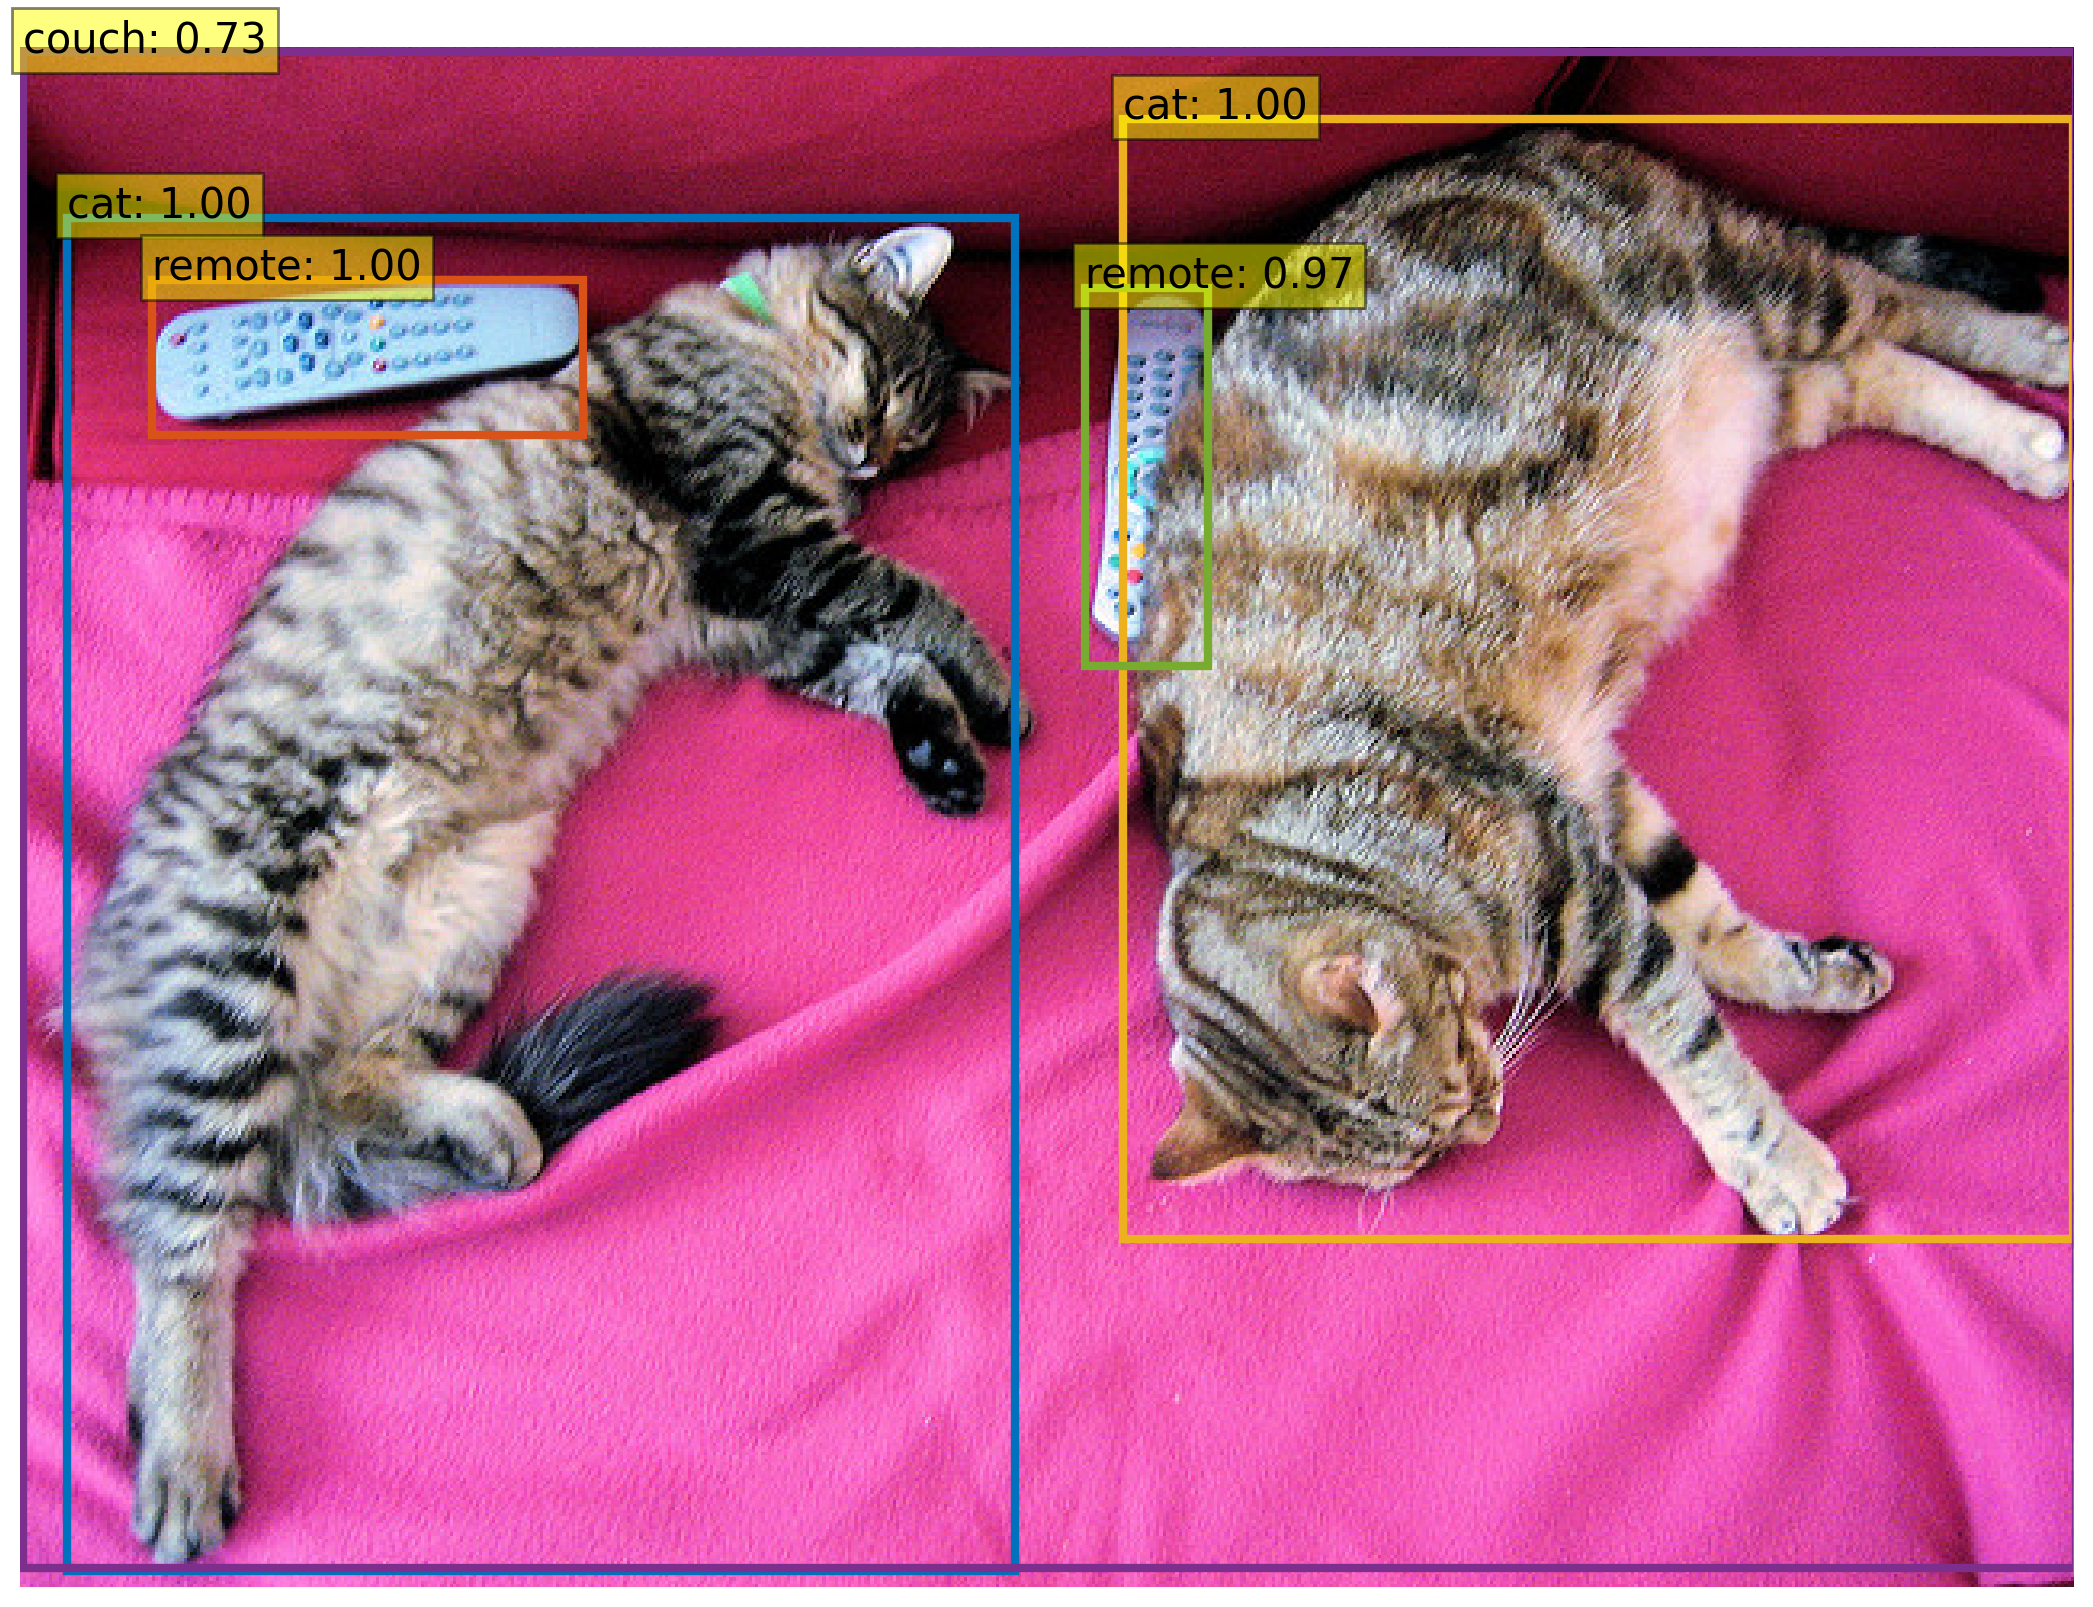

In [9]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(im, scores, boxes)